# NLP - AEVO

**Nesse notebook foi desenvolvido dois projetos de aplicação de NLP:**

1. O primeiro é um problema comum na área, principalmente para iniciantes em NLP, que é uma classificação binária de tweets, gostei do dataset pois foge um pouco da análise de sentimentos. Preferi utilizar um dataset em inglês pela facilidade de utilizar modelos pré-treinados (Transformers). A ideia do problema é classificar se o tweet é sobre um desastre ou não.

[Já escrevi um pouco sobre Chatbots e BERT no medium!](https://medium.com/geleia/introdu%C3%A7%C3%A3o-a-chatbot-e-nlp-1c88c1df5ad7)

2. Como já havia utilizado um dataset em inglês e formatado, no segundo problema escolhi criar meu dataset utilizando o Twitter API, com a finalidade em buscar informações dentro da categoria **inovação**, buscar entidades com NER e POS Tagging. Poderia também utilizar webscraping / webcrawling para buscar noticias, blogs, etc., mas como nunca utilizei o Twitter API decidi testar.

### Bibliotecas

In [82]:
import pandas as pd
import numpy as np
import missingno as mgn
import matplotlib.pyplot as plt
import seaborn as sns
from spacy import displacy
import nltk
import gc
import spacy
import re
import tweepy
import csv
import datetime
import polyglot
import string
import operator
from textblob import TextBlob
from PIL import Image
from collections import defaultdict
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from spellchecker import SpellChecker
from polyglot.text import Text, Word
from polyglot.downloader import downloader
from yellowbrick.text import FreqDistVisualizer, PosTagVisualizer
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

import warnings
nlp = spacy.load("pt_core_news_sm")
warnings.filterwarnings("ignore")
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guireis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# downloader.download("embeddings2.pt")
# downloader.download("pos2.pt")
# downloader.download("ner2.pt")
# downloader.download("embeddings2.en")
# downloader.download("ner2.en")

In [3]:
consumer_key = 'gqPbGlNrhKXedgPSZWiYAMXTL'
consumer_secret = '40CwT8qXD2XojrUrcHl7JDfhJBIEtlOlTnRRJSroXWMmMu4YzI'
access_key= '310550023-qDcttLKeSH2AnnJR6kgheJjzLEJ1elbYsxfUzbwN'
access_secret = '2z9uyePwzvIL6OkNi4qSFtYbQEf1szcLoFBm2OlfK7GM7'

In [4]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Funções

In [5]:
def polarity_check_sayi(self):
    polarity_list = []
    for el in self['text']:
        result = TextBlob(el).sentiment.polarity
        polarity_list.append(result)

    self['polarity'] = polarity_list
    
def polarity_check_label(self):
    polarity_list = []
    for el in self['text']:
        result = TextBlob(el).sentiment.polarity
        if result < 0:
            check = 'Negative'
        elif result == 0:
            check = 'Neutral'
        else:
            check = 'Positive'
            
        polarity_list.append(check)

    self['polarity'] = polarity_list

In [6]:
def stop_word(target):
    stop_word = []
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            stop_word.append(i)
    return stop_word

In [7]:
def create(tweet, target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [8]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [9]:
def remove_pontuacao(text):
    pont = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in pont:
        text = text.replace(p, f' {p} ')
    text = text.replace('...', ' ... ')

    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [10]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [11]:
def ngram(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [12]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [13]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [14]:
def remove_numbers(self):
    result = ''.join(i for i in self if not i.isdigit())
    return(result)

In [15]:
def remove_nick_name(text):
    return re.sub(r"\@\S+", "", text)

In [16]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # simbolos
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

## Classificação de desastres de Tweets

### Análise exploratória

In [17]:
df = pd.read_csv('data/disastre.csv')

In [18]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


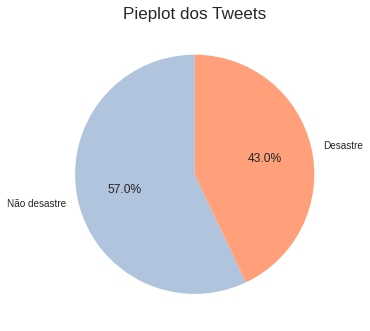

In [19]:
plt.pie(df.groupby('target').count()['id'],labels=('Não desastre', 'Desastre'), autopct='%1.1f%%',  startangle=90, colors=('lightsteelblue','lightsalmon'))
plt.title('Pieplot dos Tweets', fontsize=17)
plt.show()

*O dataset está bem balanceado*

In [20]:
# Separando em real ou não
disastre = df[df['target']==1]
nao_disastre = df[df['target']==0]

In [21]:
disastre['location'].value_counts()[:5]

USA              67
United States    27
Nigeria          22
India            20
Mumbai           19
Name: location, dtype: int64

In [22]:
nao_disastre['location'].value_counts()[:5]

New York           55
USA                37
London             29
United States      23
Los Angeles, CA    18
Name: location, dtype: int64

**Exemplo**

In [23]:
disastre['text'].loc[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [24]:
nao_disastre['text'].loc[18]

'My car is so fast'

Estamos procurando palavras como "earthquake", onde seria uma classificação de desastre

**Observando os valores nulos**

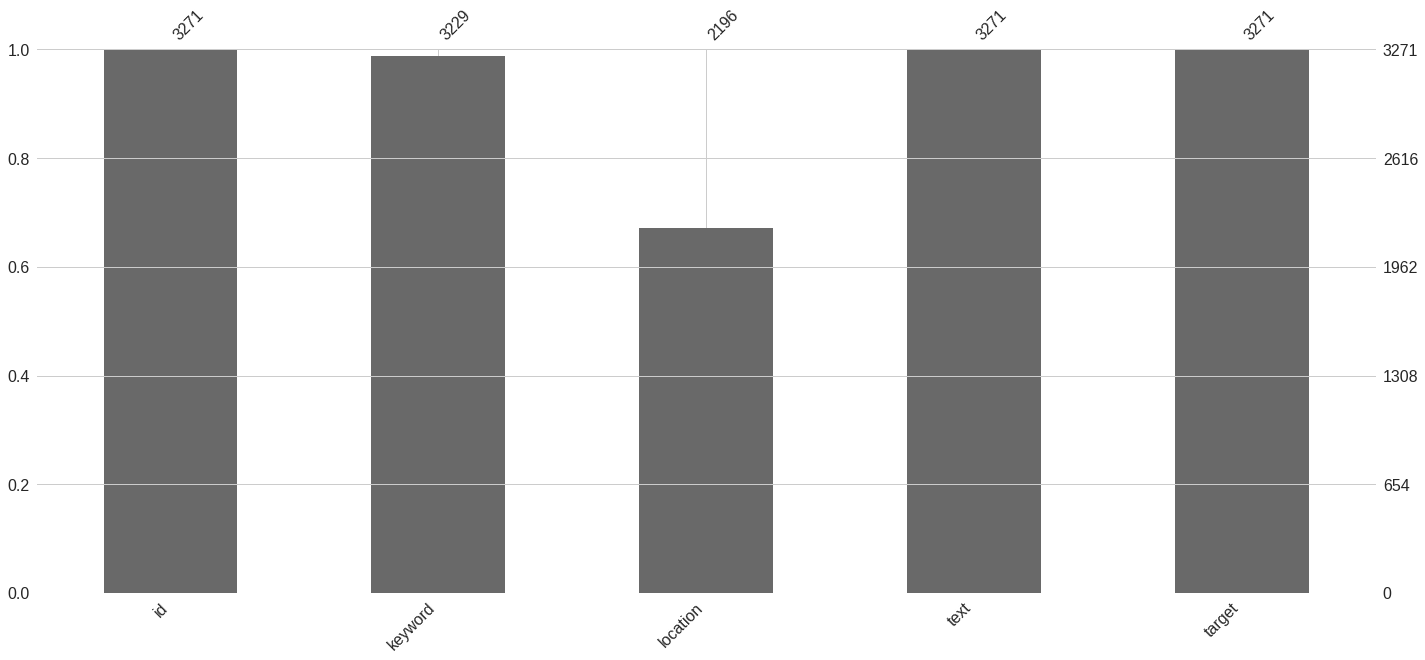

In [25]:
mgn.bar(disastre)
plt.grid(False)
plt.show()

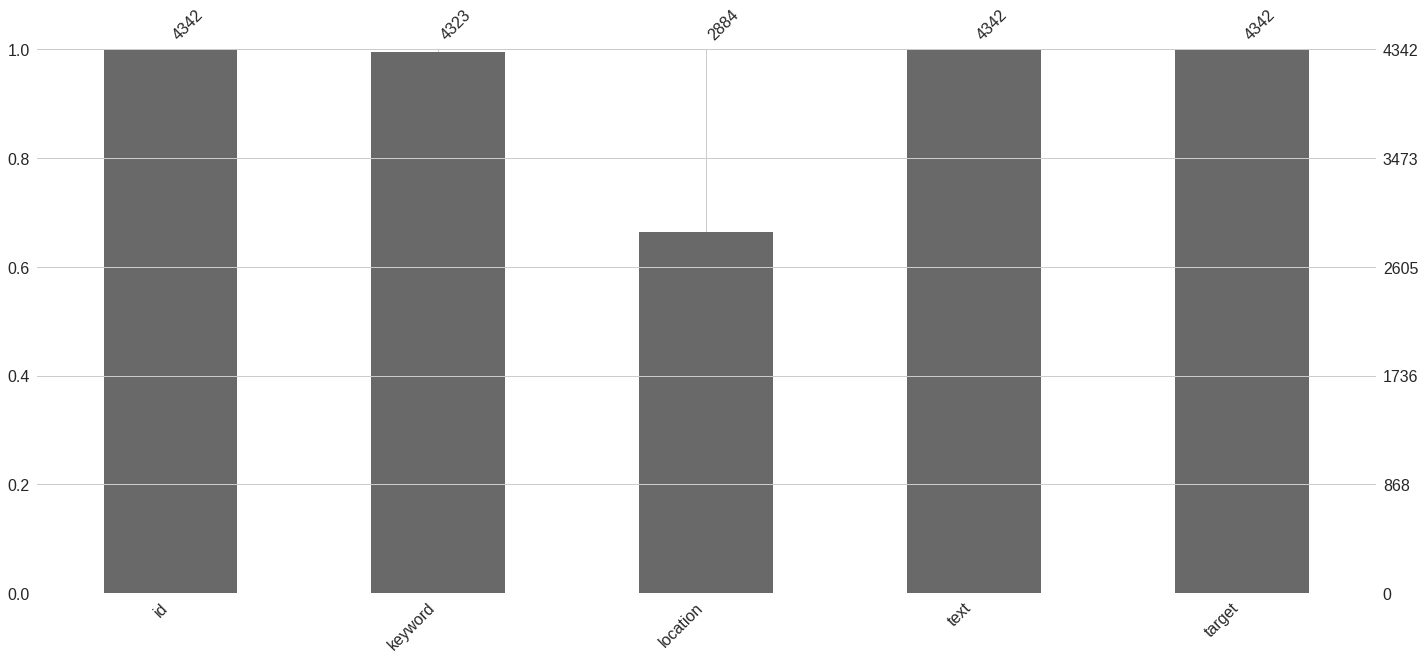

In [26]:
mgn.bar(nao_disastre)
plt.grid(False)
plt.show()

**Número de caracteres**

In [27]:
print('A média do número de caracteres no texto:',df['text'].str.len().sum()/df.shape[0])
print('A média do número de caracteres em desastres:',disastre['text'].str.len().sum()/disastre.shape[0])
print('A média do número de caracteres em não desastres:',nao_disastre['text'].str.len().sum()/nao_disastre.shape[0])

A média do número de caracteres no texto: 101.03743596479706
A média do número de caracteres em desastres: 108.11342097217977
A média do número de caracteres em não desastres: 95.70681713496084


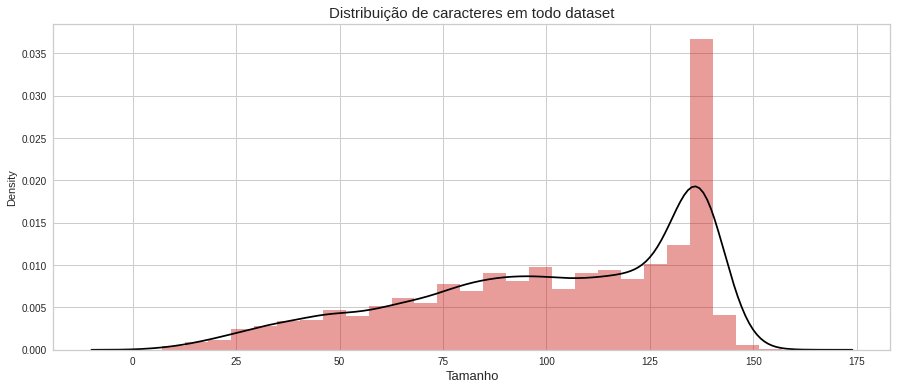

In [28]:
plt.rcParams['figure.figsize'] = (15, 6.0)
sns.distplot(df['text'].str.len(), kde_kws={"color": "black"},color='r')
plt.grid()
plt.title('Distribuição de caracteres em todo dataset',fontsize=15)
plt.xlabel('Tamanho',fontsize=13)
plt.grid()
plt.show()

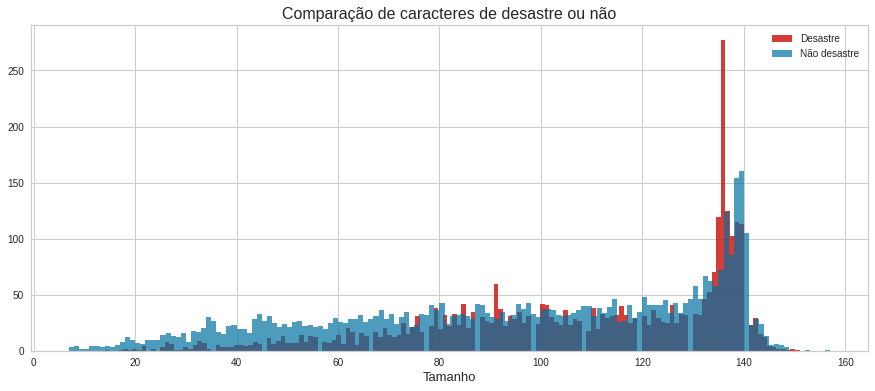

In [29]:
plt.rcParams['figure.figsize'] = (15, 6.0)
plt.hist(disastre['text'].str.len(),alpha=0.8,bins=150,color='r',label='Desastre')
plt.grid()
plt.hist(nao_disastre['text'].str.len(),alpha=0.7,bins=150,color='b',label='Não desastre')
plt.xlabel('Tamanho',fontsize=13)
plt.title('Comparação de caracteres de desastre ou não',fontsize=16)
plt.legend()
plt.grid()
plt.show()

**Podemos observar a semelhança de tweets de desastres e não desastres, tanto em número de caracter e nulos**

**Número de palavras**

In [30]:
print('A média do número de palavras no texto:',df['text'].str.split().map(lambda x: len(x)).sum()/df.shape[0])
print('A média do número de palavras em desastre:',disastre['text'].str.split().map(lambda x: len(x)).sum()/disastre.shape[0])
print('A média do número de palavras em não desastre:',nao_disastre['text'].str.split().map(lambda x: len(x)).sum()/nao_disastre.shape[0])

A média do número de palavras no texto: 14.903585971364771
A média do número de palavras em desastre: 15.167532864567411
A média do número de palavras em não desastre: 14.704744357438969


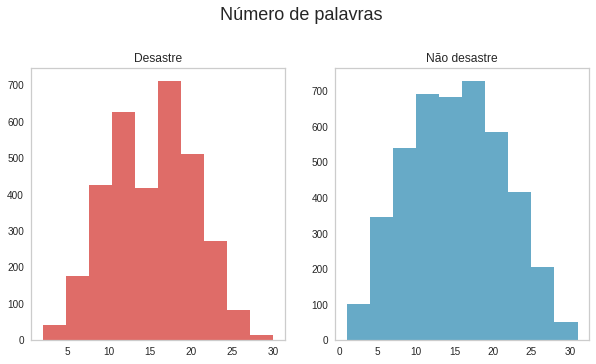

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(disastre['text'].str.split().map(lambda x: len(x)),alpha=0.6,color='r')
ax1.grid(False)
ax2.hist(nao_disastre['text'].str.split().map(lambda x: len(x)),alpha=0.6,color='b')
ax1.set_title('Desastre')
ax2.set_title('Não desastre')
fig.suptitle('Número de palavras',fontsize=18,y=1.05)
ax2.grid(False)
plt.show()

**Stop words**

É importante tirarmos as palavras vazias, como "é", "os", "eles".

Para isso, utilizei a famosa biblioteca NLTK para remove-los.


In [32]:
df['stop_word'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

**Separando entre targets para observar stop words comuns**

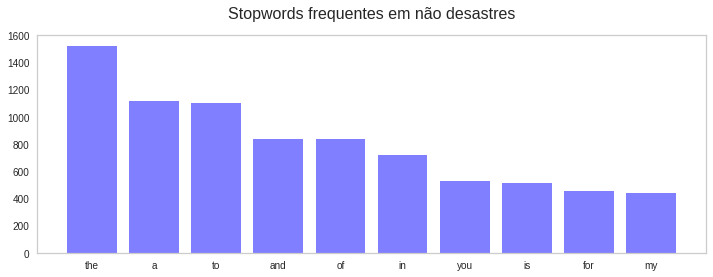

In [33]:
corpus = stop_word(0)
dic = defaultdict(int) # gosto de utilizar default dict na criação de dicionários, para não apresentar erros
for palavra in corpus:
    if palavra in stop:
        dic[palavra]+=1
        
top0 = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top0)

plt.rcParams['figure.figsize'] = (12.0, 4.0)
x,y=zip(*top0)
plt.bar(x,y,color='blue',alpha=0.5)
plt.grid(False)
plt.title('Stopwords frequentes em não desastres',fontsize=16,y=1.05)
plt.show()

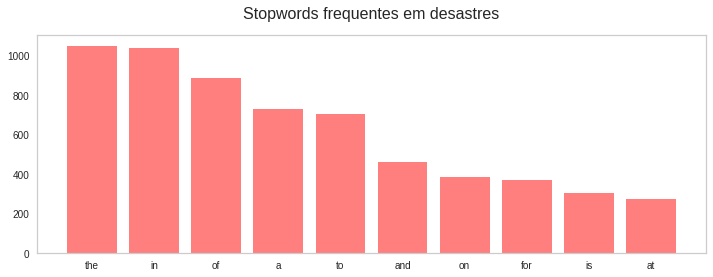

In [34]:
corpus = stop_word(1)

dic=defaultdict(int)
for palavra in corpus:
    if palavra in stop:
        dic[palavra]+=1

top1 = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
plt.rcParams['figure.figsize'] = (12.0, 4.0)
x,y=zip(*top1)
plt.bar(x,y,color='red',alpha=0.5)
plt.grid(False)

plt.title('Stopwords frequentes em desastres',fontsize=16,y=1.05)
plt.show()

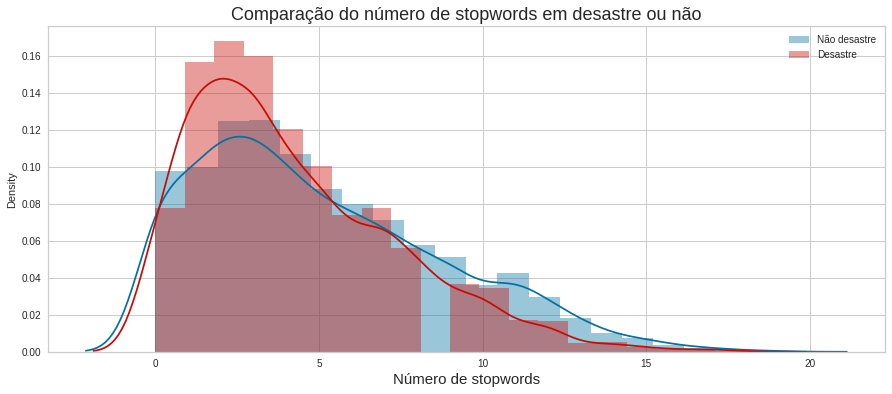

In [35]:
plt.rcParams['figure.figsize'] = (15, 6.0)
sns.distplot(df[df['target']==0]['stop_word'],bins=20,label='Não desastre',color='b')
plt.grid()
sns.distplot(df[df['target']==1]['stop_word'],bins=20,label='Desastre',color='r')
plt.xlabel('Número de stopwords',fontsize=15)
plt.title('Comparação do número de stopwords em desastre ou não',fontsize=18)
plt.legend()
plt.grid()
plt.show()

**Word Cloud**

In [36]:
twitter_mask = np.array(Image.open("data/twitter_logo.png"))

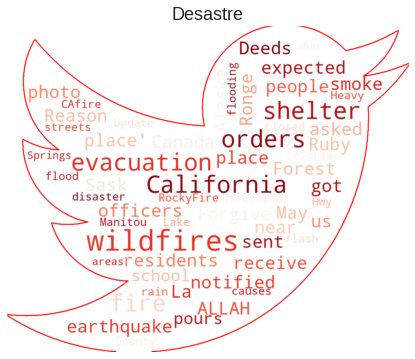

In [37]:
palavra = create(df,1)
word_cloud = WordCloud(mask=twitter_mask,background_color='white',max_font_size=80,min_font_size=20,colormap="Reds",contour_width=2, contour_color='red').generate(" ".join(palavra[:100]))
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Desastre',fontsize=18)
plt.show()

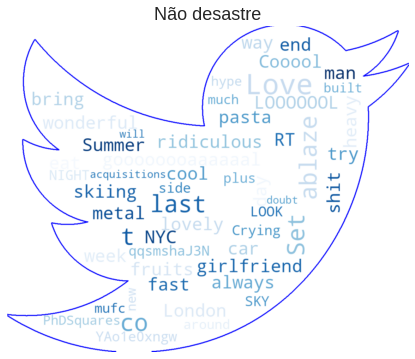

In [38]:
palavra_nao = create(df,0)
word_cloud = WordCloud(mask=twitter_mask,background_color='white',max_font_size=80,min_font_size=20,colormap="Blues",contour_width=2, contour_color='blue').generate(" ".join(palavra_nao[:100]))
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Não desastre',fontsize=18)
plt.show()

*Podemos observar palavras como "evacuation", "Shelter", "wildfires" em desastres e palavras como "NYC", "Summer", "Girlfriend" em não desastres. Portanto, imagino que um simples classificador consegue resolver o problema*

**Removendo Pontuação, html, url, emoticons/simbolo, lowercase, correção de palavras**

*Próximo passo do EDA é fazer uso dos N-grans, para isso é preciso um melhor pré processamento do texto*

In [39]:
df['text'] = df['text'].apply(lambda x : remove_nick_name(x))
df['text'] = df['text'].apply(lambda x : remove_emoji(x))
df['text'] = df['text'].apply(lambda x : remove_html(x))
df['text'] = df['text'].apply(lambda x : remove_numbers(x))
df['text'] = df['text'].apply(lambda x : remove_URL(x))
df['text'] = df['text'].apply(lambda x : remove_punct(x))
# df['text'] = df['text'].apply(lambda x : correct_spellings(x))
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

**N-grans**

In [40]:
disastre = df[df['target']==1]
nao_disastre = df[df['target']==0]

In [41]:
disastre_unigrams = defaultdict(int)
nao_disastre_unigrams = defaultdict(int)

for tweet in disastre['text']:
    for word in ngram(tweet, n_gram=1):
        disastre_unigrams[word] += 1
        
for tweet in nao_disastre['text']:
    for word in ngram(tweet, n_gram=1):
        nao_disastre_unigrams[word] += 1
        
df_disastre_unigrams = pd.DataFrame(sorted(disastre_unigrams.items(), key=lambda x: x[1])[::-1])
df_nao_disastre_unigrams = pd.DataFrame(sorted(nao_disastre_unigrams.items(), key=lambda x: x[1])[::-1])

In [42]:
disastre_bigrams = defaultdict(int)
nao_disastre_bigrams = defaultdict(int)

for tweet in disastre['text']:
    for word in ngram(tweet, n_gram=2):
        disastre_bigrams[word] += 1
        
for tweet in nao_disastre['text']:
    for word in ngram(tweet, n_gram=2):
        nao_disastre_bigrams[word] += 1
        
df_disastre_bigrams = pd.DataFrame(sorted(disastre_bigrams.items(), key=lambda x: x[1])[::-1])
df_nao_disastre_bigrams = pd.DataFrame(sorted(nao_disastre_bigrams.items(), key=lambda x: x[1])[::-1])

In [43]:
disastre_trigrams = defaultdict(int)
nao_disastre_trigrams = defaultdict(int)

for tweet in disastre['text']:
    for word in ngram(tweet, n_gram=3):
        disastre_trigrams[word] += 1
        
for tweet in nao_disastre['text']:
    for word in ngram(tweet, n_gram=3):
        nao_disastre_trigrams[word] += 1
        
df_disastre_trigrams = pd.DataFrame(sorted(disastre_trigrams.items(), key=lambda x: x[1])[::-1])
df_nao_disastre_trigrams = pd.DataFrame(sorted(nao_disastre_trigrams.items(), key=lambda x: x[1])[::-1])

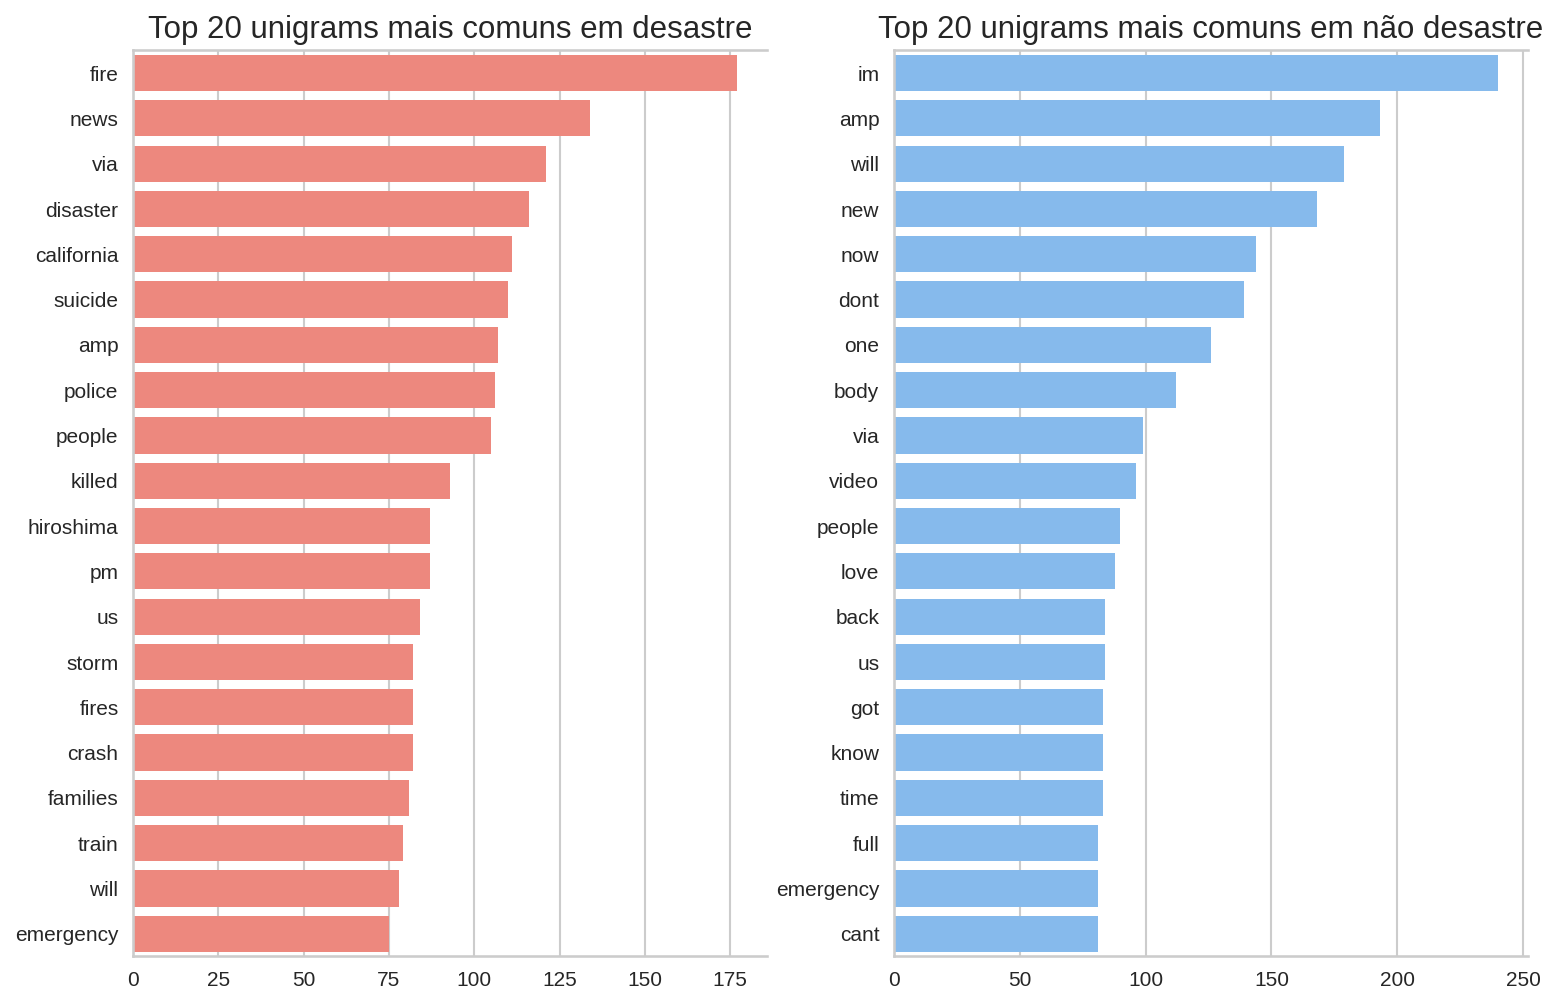

In [50]:
fig,axes=plt.subplots(ncols=2,figsize=(12,8),dpi=150)
sns.barplot(y=df_disastre_unigrams[0][:20],x=df_disastre_unigrams[1][:20],ax=axes[0],color='#ff796c' )
sns.barplot(y=df_nao_disastre_unigrams[0][:20],x=df_nao_disastre_unigrams[1][:20],ax=axes[1],color='#75bbfd' )
axes[0].set_title(f'Top {20} unigrams mais comuns em desastre', fontsize=15)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel('')
axes[0].set_xlabel('')

axes[1].set_title(f'Top {20} unigrams mais comuns em não desastre', fontsize=15)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')


plt.show()

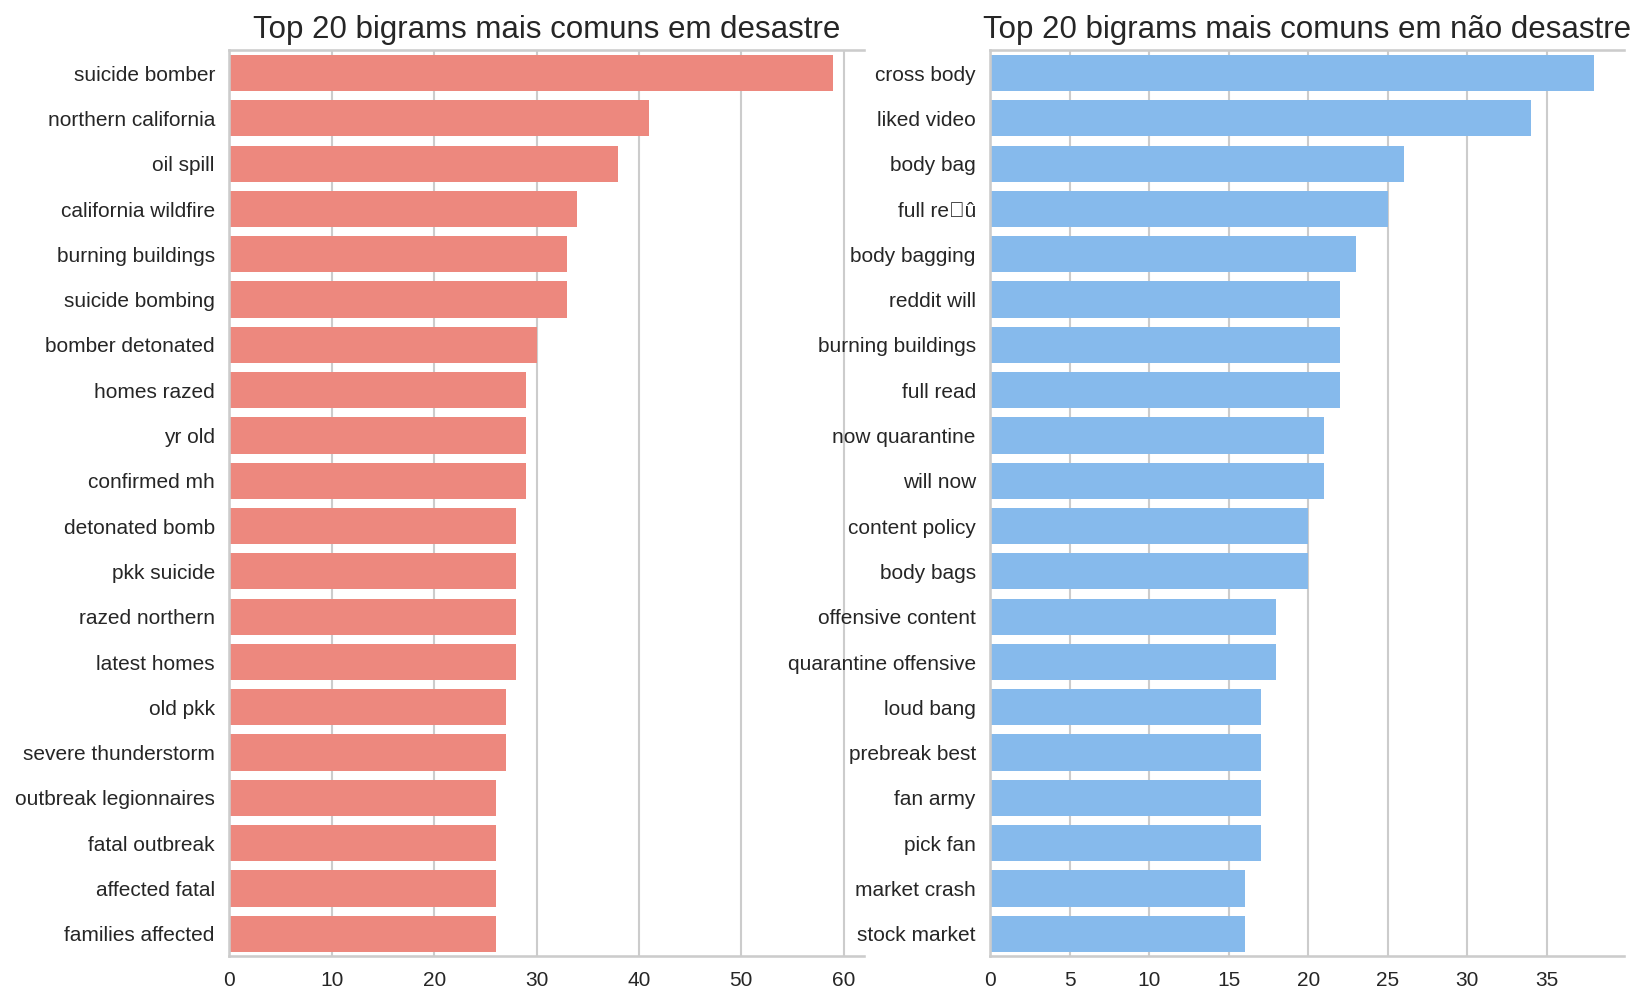

In [52]:
fig,axes=plt.subplots(ncols=2,figsize=(12,8),dpi=150)

sns.barplot(y=df_disastre_bigrams[0][:20],x=df_disastre_bigrams[1][:50],ax=axes[0],color='#ff796c' )
sns.barplot(y=df_nao_disastre_bigrams[0][:20],x=df_nao_disastre_bigrams[1][:50],ax=axes[1],color='#75bbfd')
axes[0].set_title(f'Top {20} bigrams mais comuns em desastre', fontsize=15)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_title(f'Top {20} bigrams mais comuns em não desastre', fontsize=15)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.show()

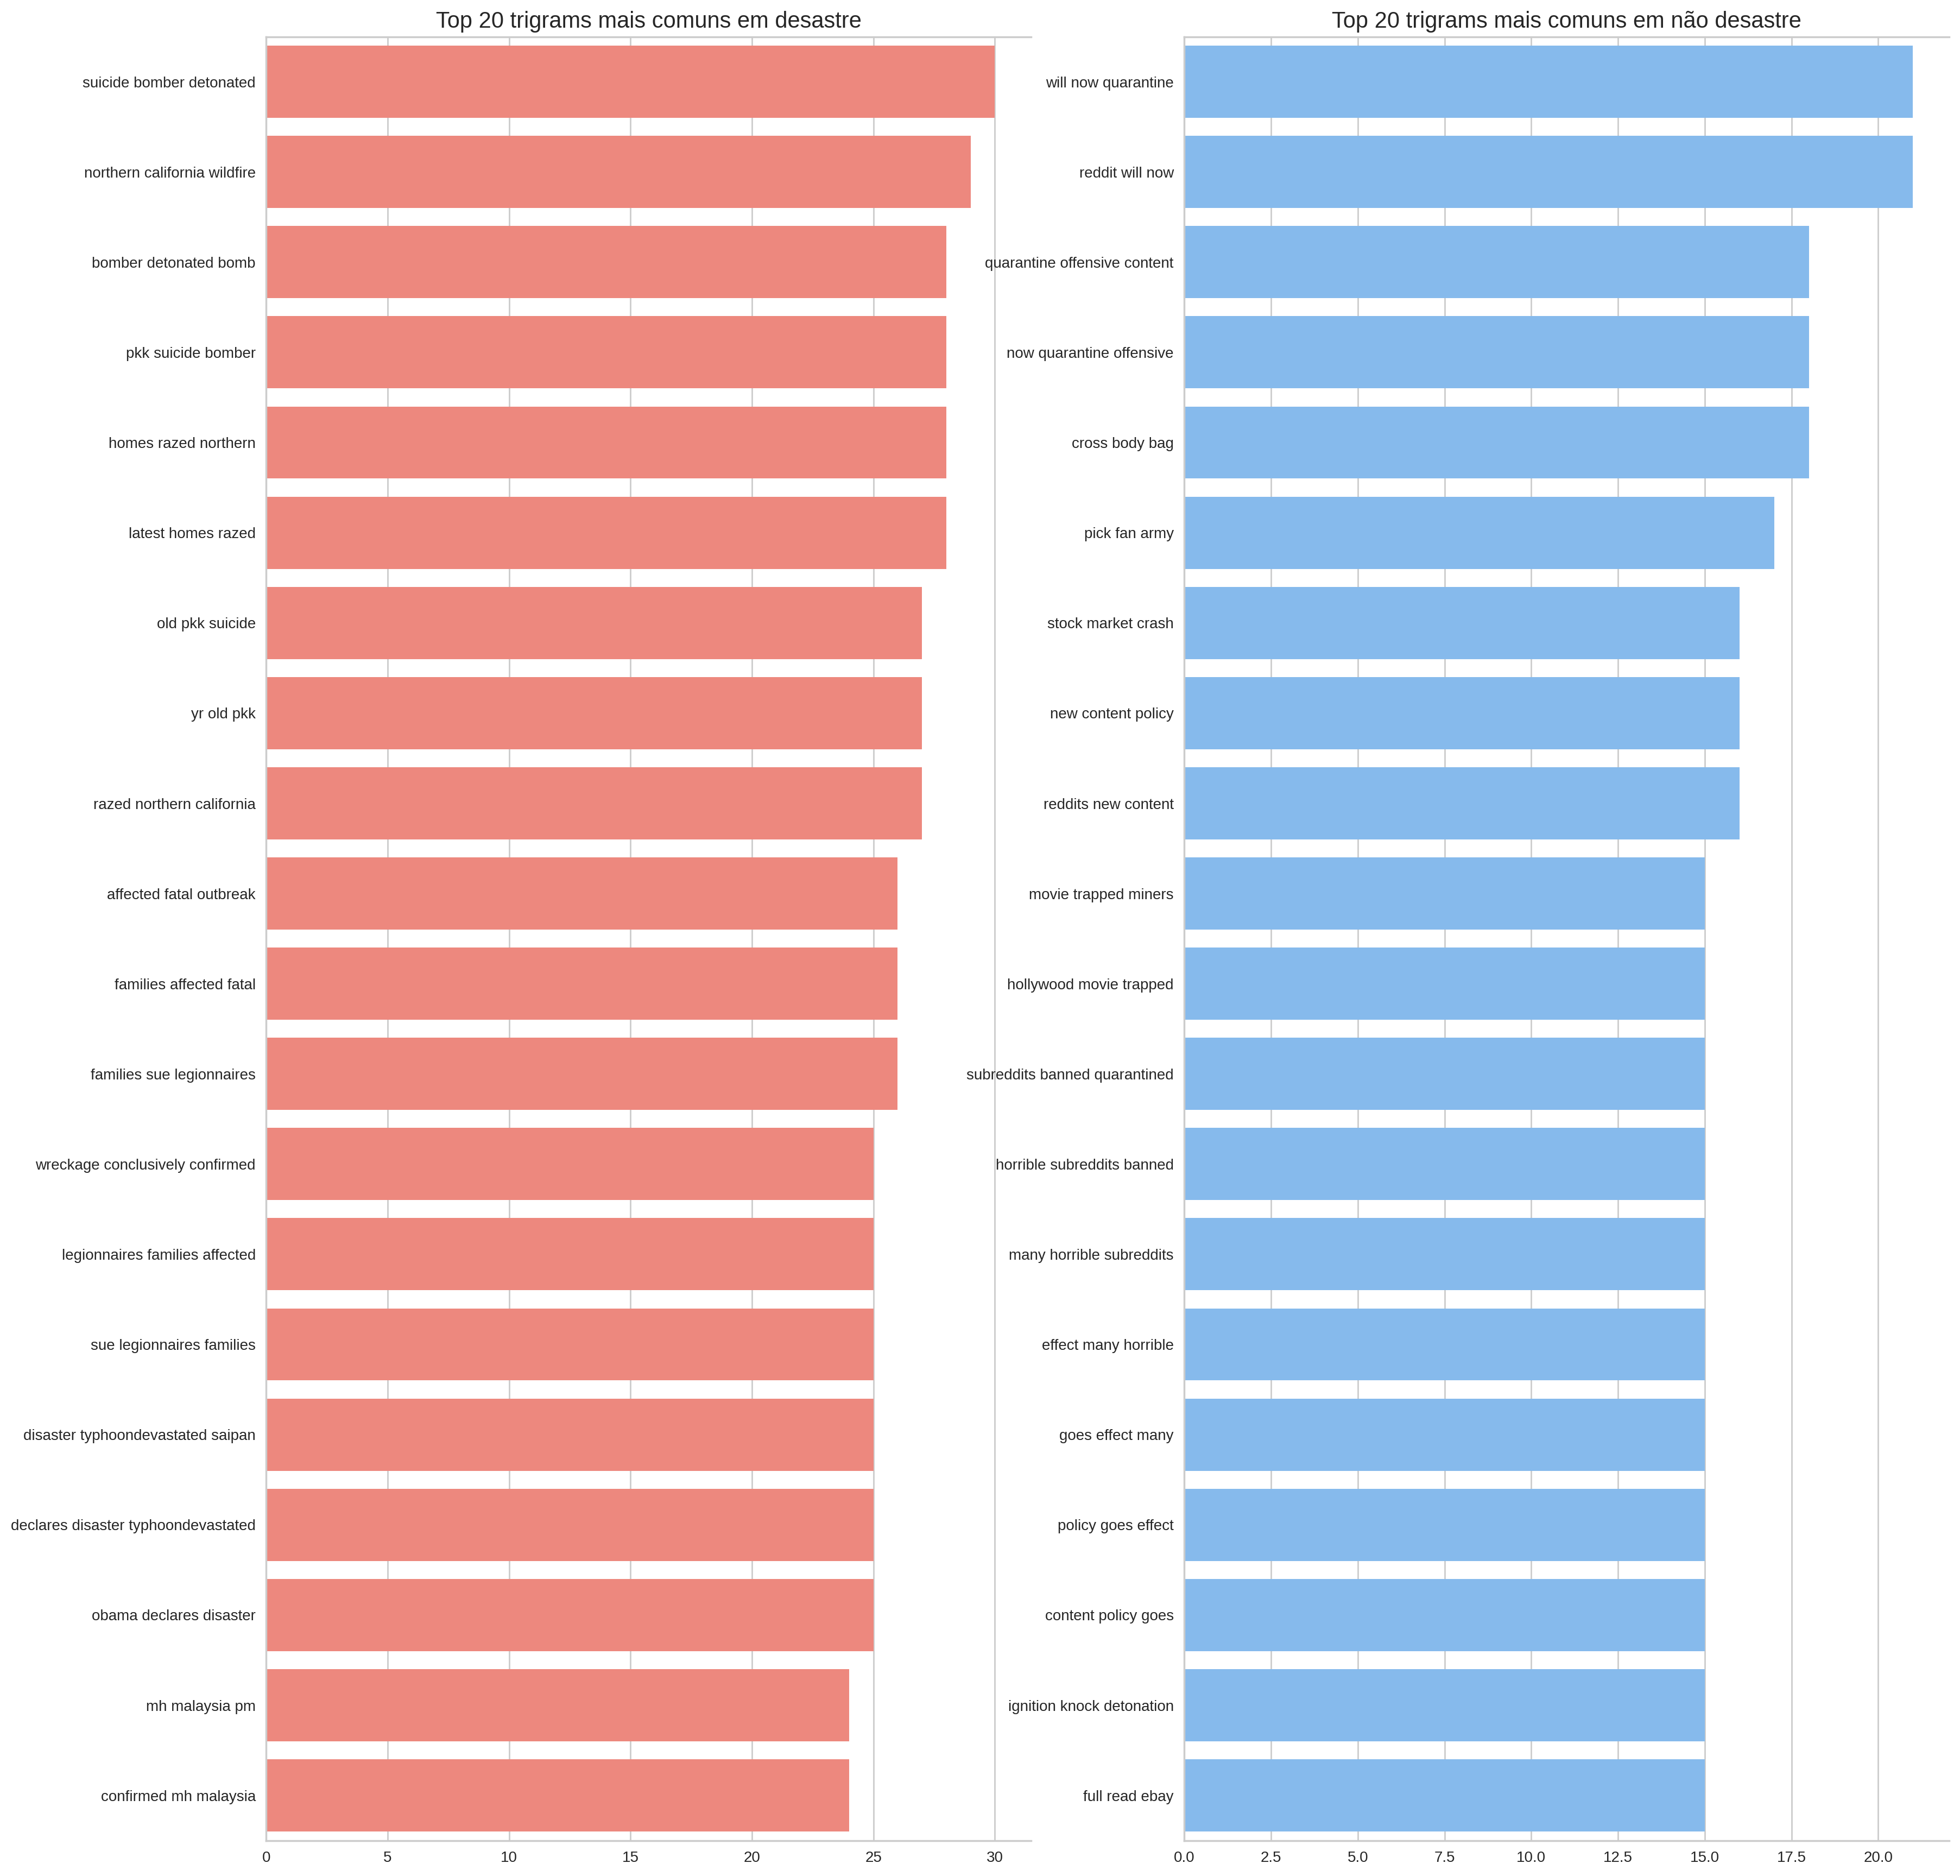

In [57]:
fig,axes=plt.subplots(ncols=2,figsize=(20,22),dpi=200)

sns.barplot(y=df_disastre_trigrams[0][:20],x=df_disastre_trigrams[1][:20],ax=axes[0],color='#ff796c' )
sns.barplot(y=df_nao_disastre_trigrams[0][:20],x=df_nao_disastre_trigrams[1][:20],ax=axes[1],color='#75bbfd' )
axes[0].set_title(f'Top {20} trigrams mais comuns em desastre', fontsize=15)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_title(f'Top {20} trigrams mais comuns em não desastre', fontsize=15)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.show()

*De novo, podemos ver a distinção entre os targets, reforçando o sucesso de um futuro modelo classificador*

**Teste de sentimento**

*Utilizarei um modelo prétreinado do TextBlob para fazer uma rápida análise de sentimentos*

In [58]:
polarity_check_label(df)
var = df.groupby(['target','polarity']).count().rename(columns={'column1':'columns2'}).reset_index()

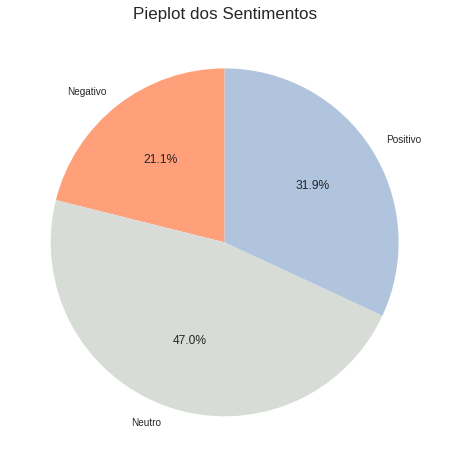

In [60]:
plt.figure(figsize=(8,8))
plt.pie(df.groupby('polarity').count()['id'],labels=('Negativo', 'Neutro', 'Positivo'), autopct='%1.1f%%',  startangle=90, colors=('lightsalmon','#d8dcd6','lightsteelblue'))
plt.title('Pieplot dos Sentimentos', fontsize=17)
plt.show()

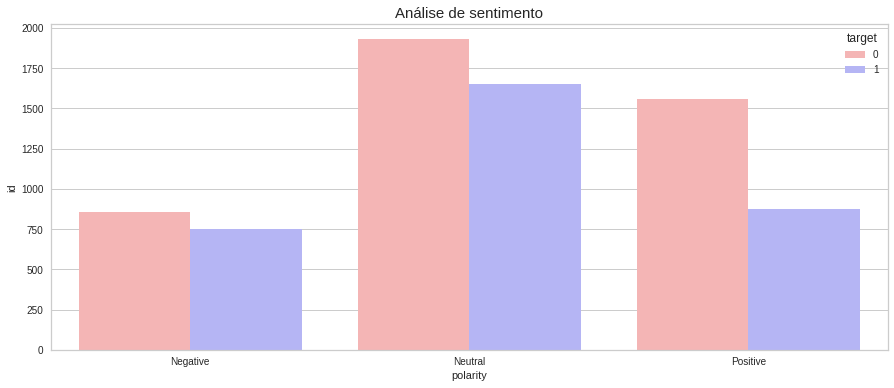

In [62]:
sns.barplot(data=var,x="polarity", y='id', hue='target',ci="sd", palette="bwr_r")
plt.title('Análise de sentimento',fontsize=15)
plt.show()

## Modelagem

In [48]:
train, test = train_test_split(df,test_size=0.3, stratify=df['target'])
train.to_csv('data/train_desastre.csv')
test.to_csv('data/test_desastre.csv')

**Para a modelagem, utilizaremos dois modelos:**

1. Bert
2. TF Idf


**BERT**

No modelo Bert, foi utilizado o modelo pré-treinado extraido do **TFHub**, e foi feito um treinamento de **fine-tuning** utilizando a partição "treino" do dataset pré processado. Os transformadores são o atual estado da arte em NLP, estou utilizando o Bert por ser o modelo que trouxe os **transformadores** para as redes de NLP, mas atualmente existem modelos mais aprimorados e eficientes.

O treino foi feito no script ***bert.py*** utilizado a GPU oferecido pelo *Google Colab*, o modelo treinado foi salvo na pasta ***model***.

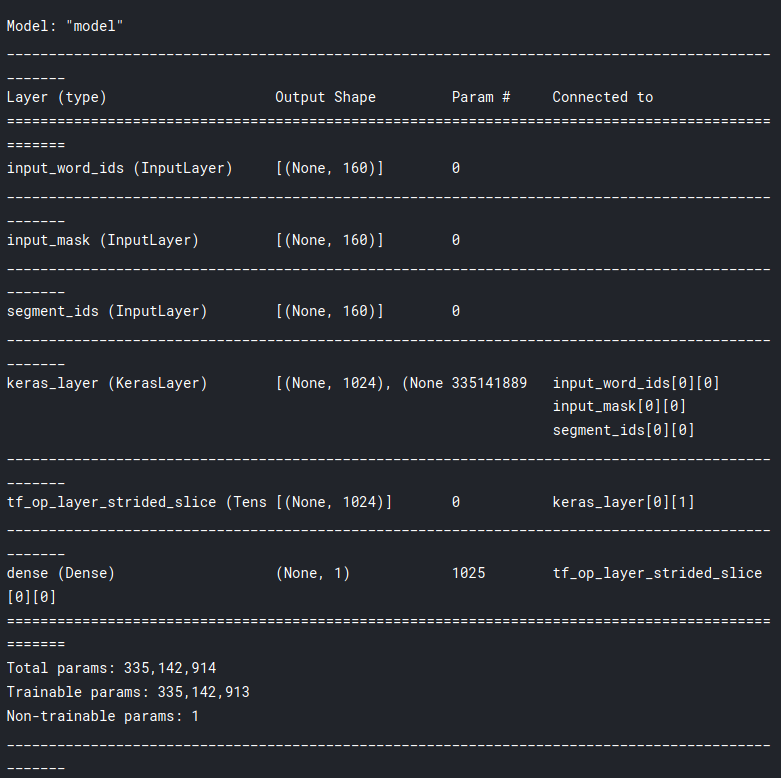

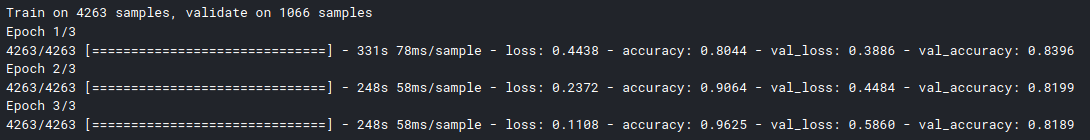

O modelo tem 4GB, então para facilitar, foi feito a predição do dataset de test depois do treino, o mesmo se encontra em **"data/test_pred.csv"**, vamos utiliza-lo para analises.

In [62]:
predict = pd.read_csv("data/test_pred.csv")

In [68]:
predict_merge = pd.concat([test.reset_index(),predict.rename(columns={'target':'pred'})],axis=1)

In [75]:
predict_merge.head()

,index,id,keyword,location,text,target,stop_word,polarity,pred
0,5605,7999,razed,NaN,the latest more homes razed by northern califo...,1,3,Positive,1
1,7019,10060,typhoon,"calgary, ab, canada",find out how your fund was used for typhoon ha...,1,7,Neutral,1
2,5209,7439,obliterated,leyland,very glad that you got obliterated in x men fi...,0,8,Positive,0
3,2177,3120,debris,nbc washington,nbcnightlynews malaysian officials say debris ...,1,3,Neutral,1
4,3004,4317,dust%20storm,d(m)v,people in sydney woke up to the whole sky bei...,1,7,Positive,1


In [82]:
print(classification_report(predict_merge['target'], predict_merge['pred'],target_names=['Não desastre','Desastre']))

              precision    recall  f1-score   support

Não desastre       0.82      0.91      0.86      1303
    Desastre       0.86      0.74      0.79       981

    accuracy                           0.84      2284
   macro avg       0.84      0.82      0.83      2284
weighted avg       0.84      0.84      0.83      2284



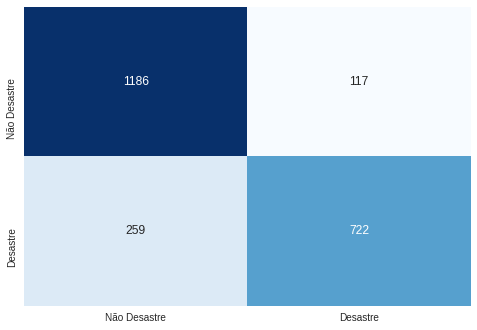

In [123]:
sns.heatmap(confusion_matrix(predict_merge['target'], predict_merge['pred']), annot=True,cmap=plt.cm.Blues, cbar=False,xticklabels=['Não Desastre','Desastre'],yticklabels=['Não Desastre','Desastre'],fmt='.4g')
plt.show()

**Tf-idf**

Agora utilizaremos um método clássico em problemas de NLP (e bem mais leve que Bert), para isso, vamos vetorizar o texto com limite de 10.000 palavras, pegando unigrams e bigrams

In [124]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [125]:
texto = train["text"]
vectorizer.fit(texto)
X_train = vectorizer.transform(texto)
dic_voc = vectorizer.vocabulary_

Optei por reduzir a dimensionalidade (fugir de **curse of dimensionality**), utilizando feature_selection com chi-square para determinar a idependência das features

In [126]:
y = train["target"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

Vamos utilizar Classificador **Naivy Bayes**, bem comum nesses tipos de problema 

In [127]:
classifier = naive_bayes.MultinomialNB()

In [128]:
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
model["classifier"].fit(X_train, y)
X_test = test["text"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [129]:
print(classification_report(test.target, predicted,target_names=['Não desastre','Desastre']))

              precision    recall  f1-score   support

Não desastre       0.76      0.94      0.84      1303
    Desastre       0.88      0.60      0.72       981

    accuracy                           0.79      2284
   macro avg       0.82      0.77      0.78      2284
weighted avg       0.81      0.79      0.79      2284



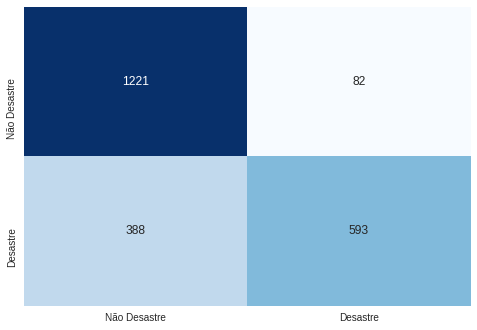

In [130]:
sns.heatmap(confusion_matrix(test.target, predicted), annot=True,cmap=plt.cm.Blues, cbar=False,xticklabels=['Não Desastre','Desastre'],yticklabels=['Não Desastre','Desastre'],fmt='.4g')
plt.show()

**Podemos observar a superioridade do BERT pelos resultados do f1-score por exemplo. É claro, os dois modelos podem ser melhorados. Mas em aplicações práticas, não é apenas o *score* que decide a implementação. Temos que levar em conta a performace e tempo de inferência. Nesse caso, o TFIdf seria extremamente superior, o BERT é um modelo pesado com milhões de parâmetros, podendo ser inutilizavel em alguns casos.**

## Tweets sobre Inovação - Análise, NER, POS Tag

*Foi extraido tweets recentes sobre **Inovação** pelo Tweepy API*

In [83]:
date_since = "2020-08-16"
search_words = "inovação"     
new_search = search_words + " -filter:retweets"

In [84]:
tweets = tweepy.Cursor(api.search,
              q=new_search,
              lang="pt",
              since=date_since,
              tweet_mode='extended').items(10000)

In [ ]:
all_hash = []
all_text = []
all_location = []
for tweet in tweets:
    for i in tweet.entities.get('hashtags'):
        all_hash.append(i['text'])
    all_location.append(tweet.user.location)
    all_text.append(tweet.full_text)

**Analisando as Hashtags**

In [ ]:
all_hash = pd.Series(all_hash).map(lambda s:s.lower() if type(s) == str else s)

In [66]:
remove = ['inovação','inovacao']
list_2 = []
for word in all_hash:
    if word not in remove:
        list_2.append(word)
all_hash = pd.Series(test_2)

In [84]:
head_mask = np.array(Image.open("data/head2.png"))

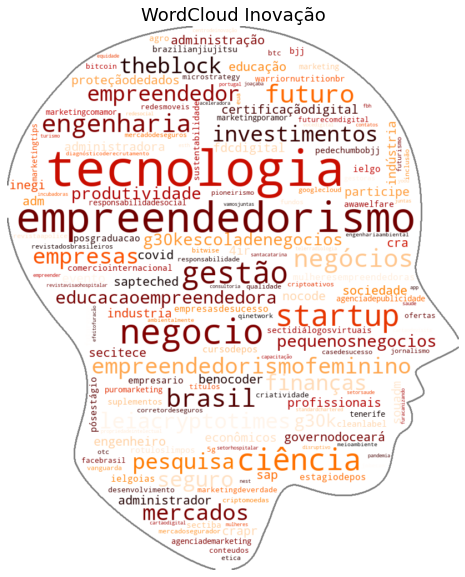

In [103]:
plt.figure(figsize=(10,10))
word_cloud = WordCloud(mask=head_mask,background_color='white',colormap="gist_heat",contour_width=3, contour_color='grey').generate(" ".join(all_hash[:200]))
plt.imshow(word_cloud,interpolation="bilinear")
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('WordCloud Inovação',fontsize=18)
plt.show()

*A WordCloud mostra a relevância de palavras como "tecnologia", "empreendedorismo", "startup", "negocio" e "ciencia" para a categoria de **Inovação**.*

**Analisando o texto**

Para POS e NER em português gosto de usar as bibliotecas Spacy e Polyglot, tem maneiras mais "poderosas", porém, essas bibliotecas já são o suficiente para o estudo.

**Part of speech Tagging**

- ADJ: adjective
- ADP: adposition
- ADV: adverb
- AUX: auxiliary verb
- CONJ: coordinating conjunction
- DET: determiner
- INTJ: interjection
- NOUN: noun
- NUM: numeral
- PART: particle
- PRON: pronoun
- PROPN: proper noun
- PUNCT: punctuation
- SCONJ: subordinating conjunction
- SYM: symbol
- VERB: verb
- X: other

**NER**

- Locations (Tag: I-LOC)
- Organizations (Tag: I-ORG)
- Persons (Tag: I-PER)

**Spacy**
- Text: The original word text.
- Lemma: The base form of the word.
- POS: The simple UPOS part-of-speech tag.
- Tag: The detailed part-of-speech tag.
- Dep: Syntactic dependency, i.e. the relation between tokens.
- Shape: The word shape – capitalization, punctuation, digits.
- is alpha: Is the token an alpha character?
- is stop: Is the token part of a stop list, i.e. the most common words of the language?

In [92]:
all_text = pd.read_csv('data/inovacao.csv')['text']

In [93]:
stop=set(stopwords.words('portuguese'))

In [94]:
all_text = all_text.apply(lambda x : remove_nick_name(x))
all_text = all_text.apply(lambda x : remove_emoji(x))
all_text = all_text.apply(lambda x : remove_html(x))
all_text = all_text.apply(lambda x : remove_numbers(x))
all_text = all_text.apply(lambda x : remove_URL(x))
all_text = all_text.apply(lambda x : remove_punct(x))
# df['text'] = df['text'].apply(lambda x : correct_spellings(x))
# all_text = all_text.apply(lambda s:s.lower() if type(s) == str else s)

In [98]:
doc = nlp(all_text[54])

**Exemplo de POS e NER:**

In [95]:
text = Text(all_text[0])
print("{:<16}{}".format("Word", "POS Tag")+"\n"+"-"*30)
for word, tag in text.pos_tags:
    print(u"{:<16}{:>2}".format(word, tag))

Word            POS Tag
------------------------------
De              PROPN
volta           NOUN
para            ADP
o               DET
futuro          NOUN
Covid           PUNCT
Futuro          PROPN
Inovação        PROPN
Educação        PROPN


In [99]:
displacy.render(doc, style="ent",jupyter=True)

**Criando visualizações do corpus inteiro**

In [70]:
ner_text = []
ner_label = []
for text in all_text:
    doc = nlp(text)
    for token in doc.ents:
        ner_text.append(token.text)
        ner_label.append(token.label_)

In [71]:
post_list = []
post_tudo = []
for text in all_text:
    doc = nlp(text)
    for token in doc:
        post_list.append((token.text, token.pos_))
    post_tudo.append([post_list])
    post_list = []

In [72]:
ner = pd.DataFrame({'texto':ner_text,'label':ner_label})

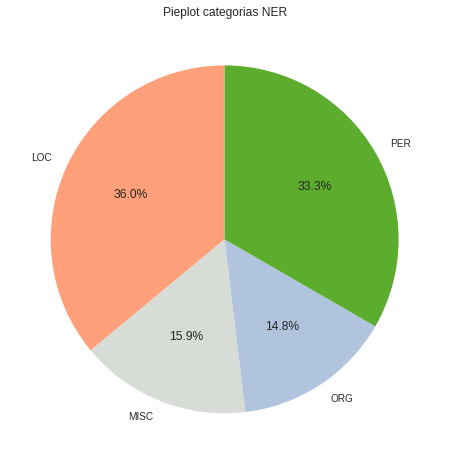

In [73]:
plt.figure(figsize=(8,8))
plt.pie(ner.groupby('label').count()['texto'],labels=('LOC','MISC','ORG','PER'),autopct='%1.1f%%',  startangle=90,colors=('lightsalmon','#d8dcd6','lightsteelblue','#5cac2d'))
plt.title('Pieplot categorias NER')
plt.show()

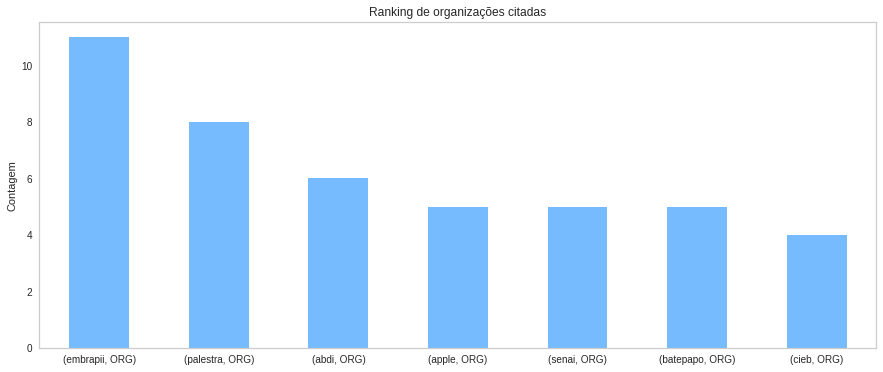

In [74]:
plt.figure(figsize=(15,6))
ner[ner['label']=='ORG'].value_counts()[:7].plot(kind='bar',color='#75bbfd')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylabel('Contagem')
plt.grid(False)
plt.title('Ranking de organizações citadas')
plt.show()

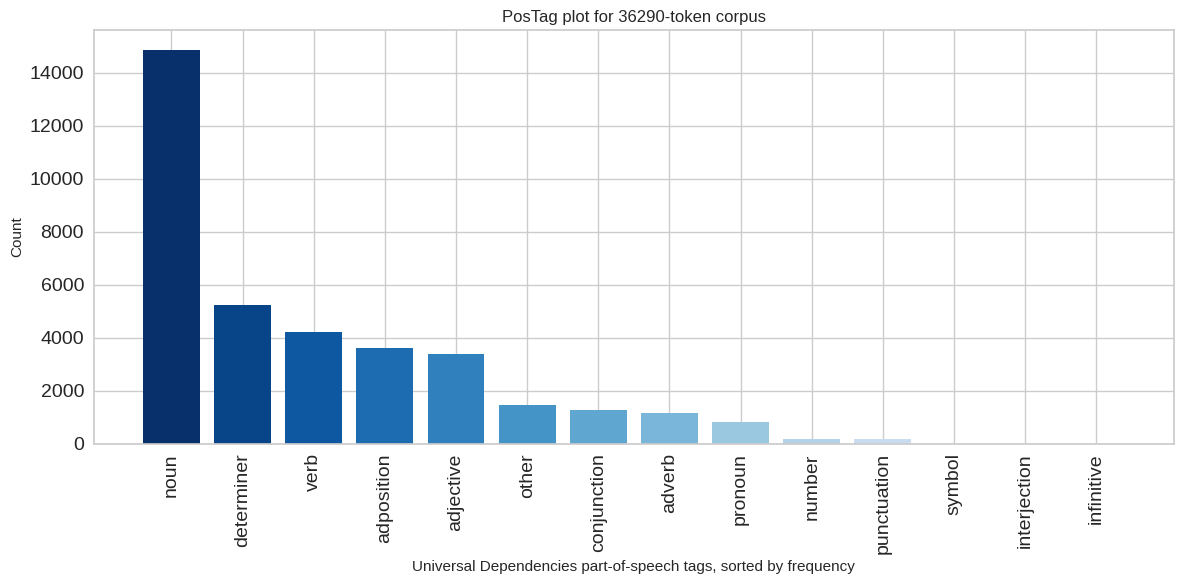

In [80]:
plt.figure(figsize=(12,6),dpi=100)
viz = PosTagVisualizer(tagset="universal",colormap='Blues_r',frequency=True)
viz.fit(post_tudo)
plt.tick_params(labelsize=14)
viz.show()
plt.show()

**N-gran**

In [76]:
all_text_stop = all_text.apply(lambda x: [w for w in str(x).lower().split() if not w in stop])
for i in range(len(all_text_stop)):
    all_text_stop.loc[i] = (" ").join(all_text_stop[i])

In [77]:
unigram = defaultdict(int)

for tweet in all_text_stop:
    for word in ngram(tweet, n_gram=1):
        unigram[word] += 1
unigram = pd.DataFrame(sorted(unigram.items(), key=lambda x: x[1])[::-1])

bigram = defaultdict(int)

for tweet in all_text_stop:
    for word in ngram(tweet, n_gram=2):
        bigram[word] += 1
bigram = pd.DataFrame(sorted(bigram.items(), key=lambda x: x[1])[::-1])

trigram = defaultdict(int)

for tweet in all_text_stop:
    for word in ngram(tweet, n_gram=3):
        trigram[word] += 1
trigram = pd.DataFrame(sorted(trigram.items(), key=lambda x: x[1])[::-1])

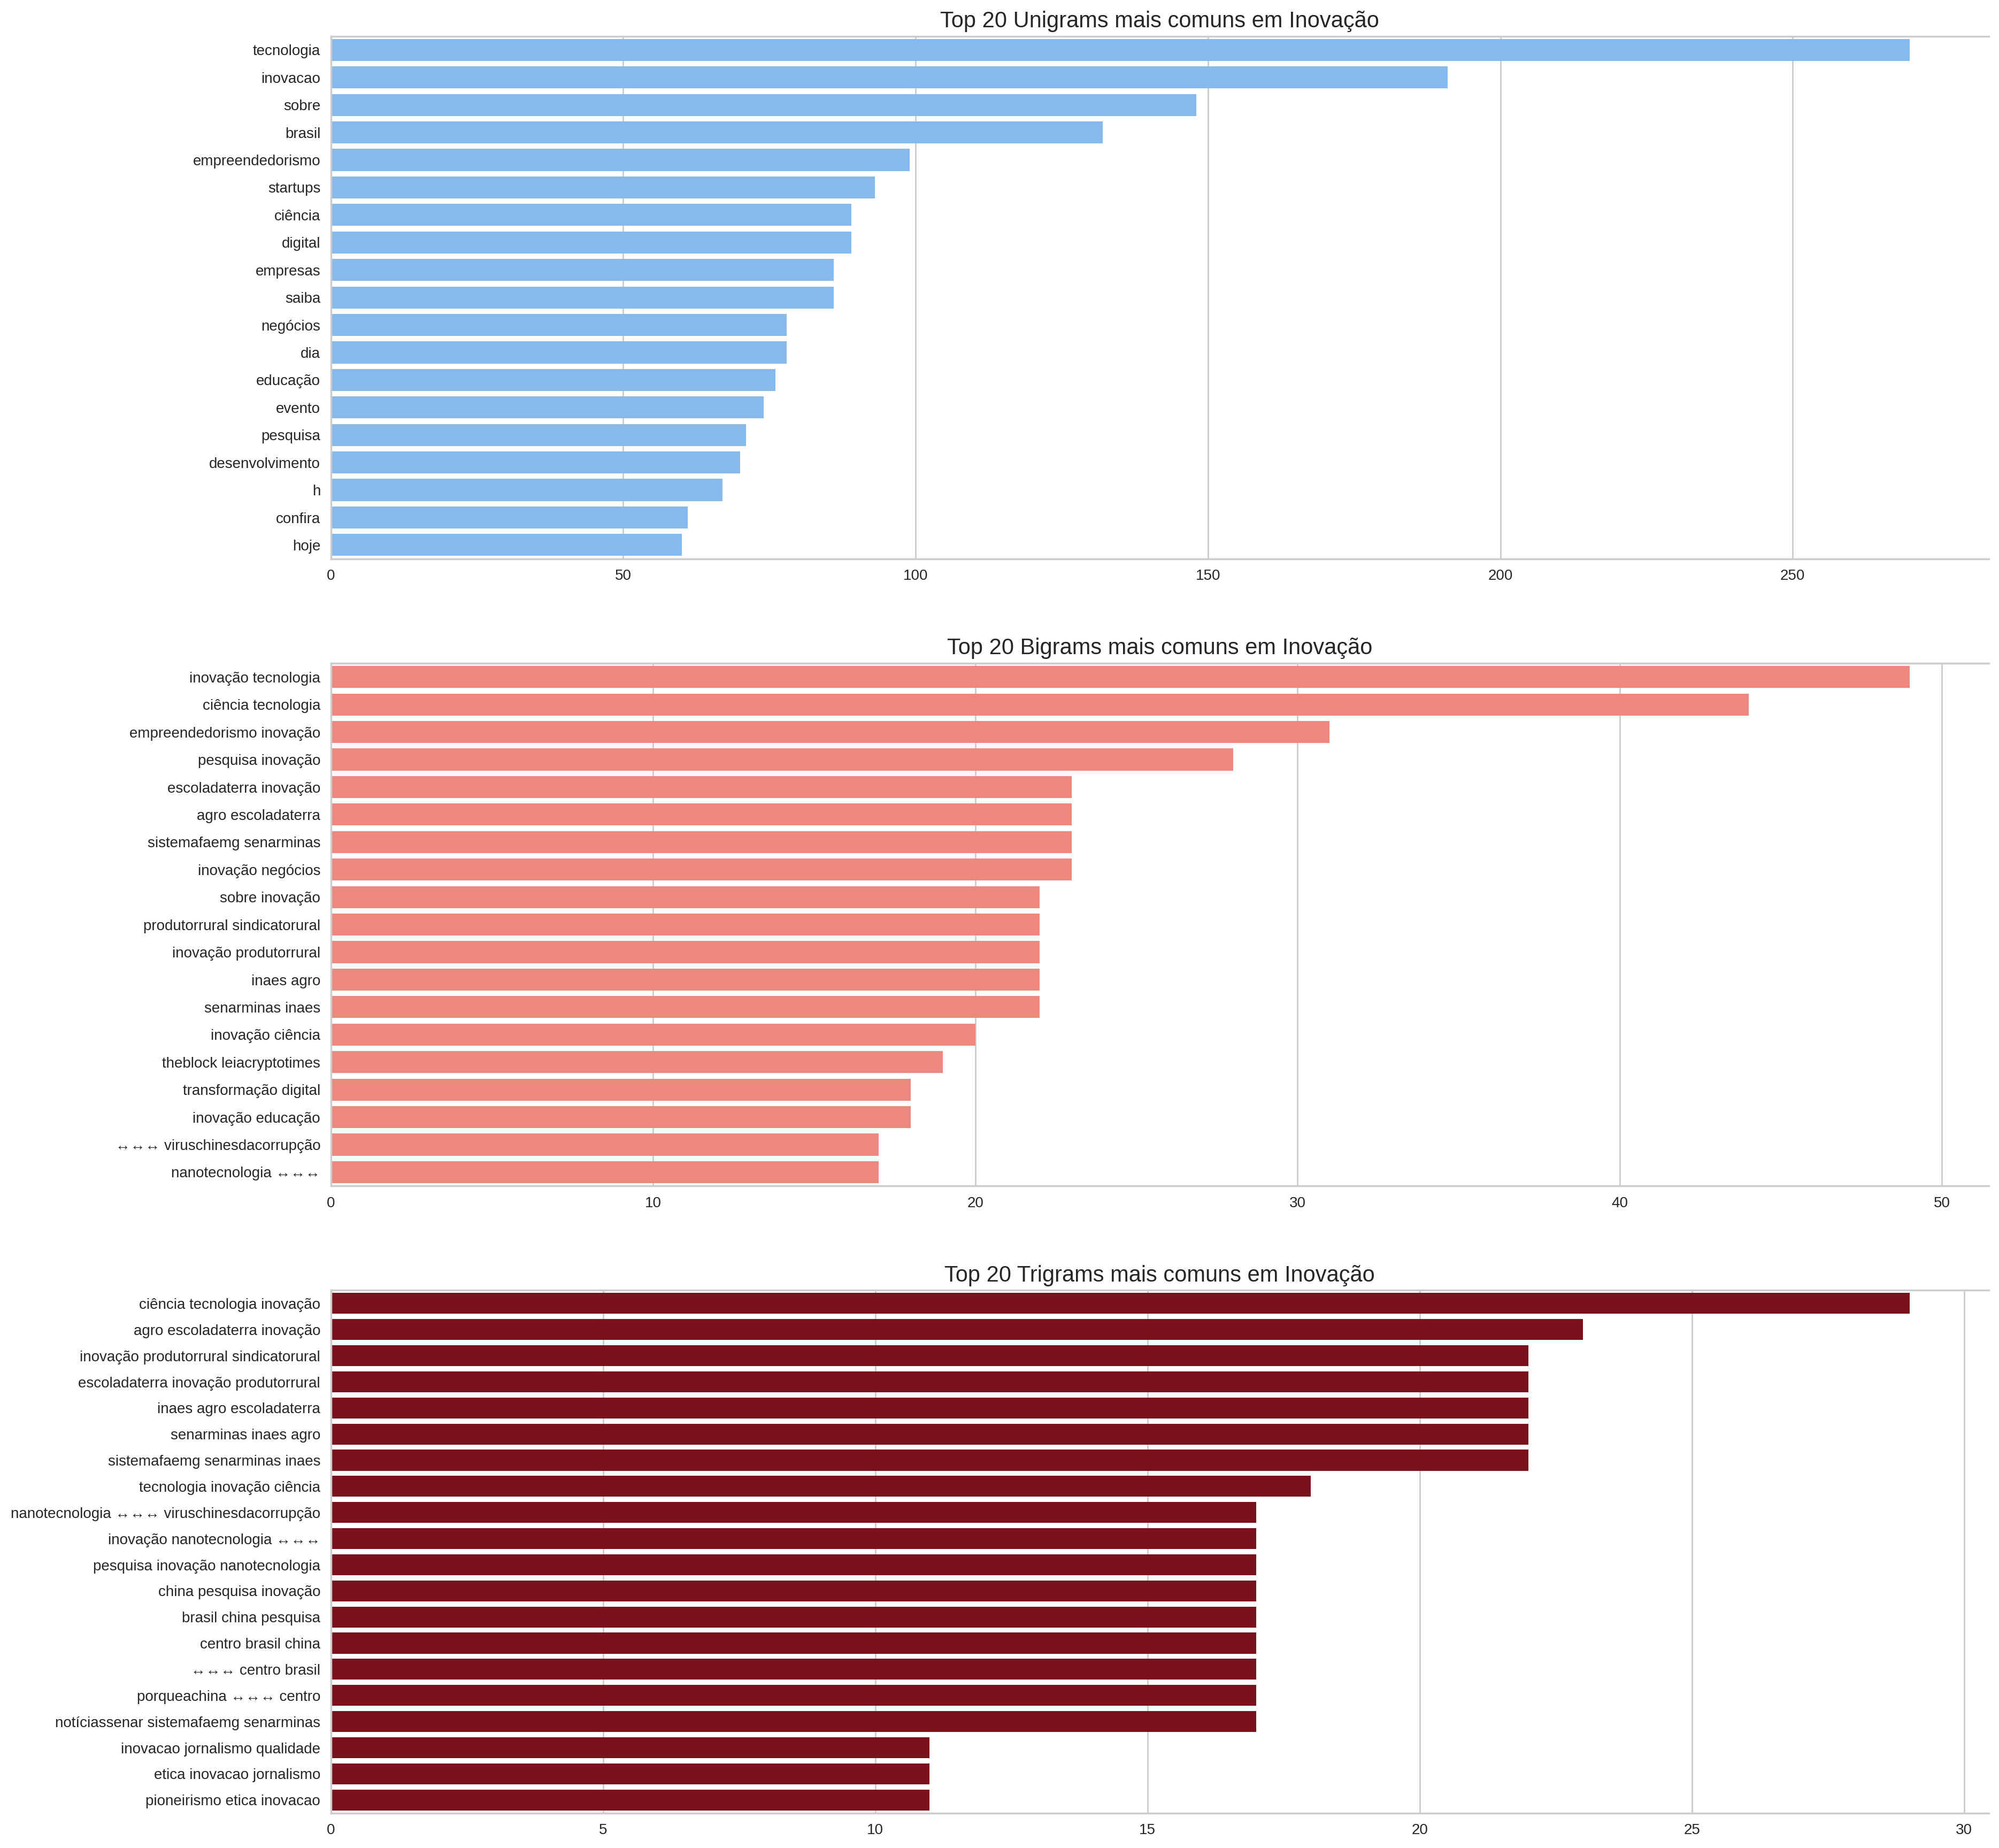

In [78]:
fig,axes=plt.subplots(nrows=3,figsize=(20,22),dpi=200)
sns.barplot(y=unigram[0][1:20],x=unigram[1][1:50],color='#75bbfd' ,ax=axes[0])
sns.barplot(y=bigram[0][1:20],x=bigram[1][1:50],color='#ff796c' ,ax=axes[1])
sns.barplot(y=trigram[0][:20],x=trigram[1][:50],color='#8c000f',ax=axes[2] )

axes[0].set_title(f'Top {20} Unigrams mais comuns em Inovação', fontsize=15)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_title(f'Top {20} Bigrams mais comuns em Inovação', fontsize=15)
axes[1].spines['right'].set_visible(False)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[2].set_title(f'Top {20} Trigrams mais comuns em Inovação', fontsize=15)
axes[2].spines['right'].set_visible(False)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
plt.show()

**Algo interessante seria observar a mudança dos tweets sobre inovação ao longo do tempo, afim de observas os diferentes pensamentos sobre inovação em relação aos anos, porém o tweepy api é um pouco limitado, o que levaria um tempo para alcançar isso.**

### **Obrigado pela atenção**

### Guilherme Reis Mendes

# **FIM**